In [ ]:
import functools
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torchtext
import tqdm
import random
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.lm import MLE
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Reading the data***

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# ***Converting into categorical integer***

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

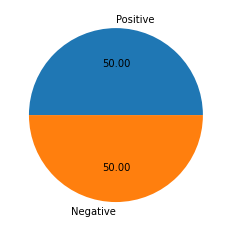

In [ ]:
plt.pie(df['sentiment'].value_counts(), labels= ['Positive', 'Negative'], autopct = "%0.2f")
plt.show()

# ***Removing punctuations from the text***

In [ ]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['clean_msg']= df['review'].apply(lambda x:remove_punctuation(x))

In [ ]:
df['tokenized_text'] = df['clean_msg'].apply(word_tokenize) 

In [ ]:
df.head(5)

,review,sentiment,clean_msg,tokenized_text
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...,"[One, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,1,A wonderful little production br br The filmin...,"[A, wonderful, little, production, br, br, The..."
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...,"[I, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,0,Basically theres a family where a little boy J...,"[Basically, theres, a, family, where, a, littl..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, in, the, Time, of, Mon..."


# ***Removing stopwords from the text***

In [ ]:
from collections import Counter
stop_words = stopwords.words('english')
def remove_stopwords(word_list):
        processed_word_list = []
        for word in word_list:
            word = word.lower() # in case they arenet all lower cased
            if word not in stop_words:
                processed_word_list.append(word)
        return processed_word_list

In [ ]:
import numpy as np
from tqdm import tqdm
msg = list(df['tokenized_text'])
nostop=[]
minm=1e9
for i in tqdm(range(len(msg))):
  if(len(msg[i])<minm):
    minm=len(msg[i])
  nostop.append(remove_stopwords(msg[i]))


100%|██████████| 50000/50000 [00:24<00:00, 2033.80it/s]


In [ ]:
y=np.asarray(df['sentiment'])

In [ ]:
nostop

# ***Training the Word2Vec on our dataset***

In [ ]:
from gensim.models import Word2Vec
w2v = Word2Vec(nostop, min_count=1,size = 100)

# ***Keeping 100 words per review and adding paddings if a data has less than 100***

In [ ]:
minm=100

In [ ]:
from tqdm import tqdm
emb=[]
for i in tqdm(range(len(nostop))):
  
    l=len(nostop[i])
    temp=np.zeros((minm,100))
    if(l<minm):
        for j in range(l):
            temp[j,:]=w2v[nostop[i][j]][:]
        for i in range(minm-l):
            temp[l+i,:]=np.zeros(100)
    else:
        for j in range(minm):
            temp[j,:]=w2v[nostop[i][j]][:]

    emb.append(temp)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
100%|██████████| 50000/50000 [00:30<00:00, 1630.96it/s]


In [ ]:
np.asarray(emb).shape

(50000, 100, 100)

# ***Train, validation and test split***

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(emb,y, train_size=0.8,random_state=41)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=41)

In [ ]:
from torch.utils.data import Dataset, DataLoader
train = DataLoader(X_train, batch_size=64,shuffle=False)
trainy= DataLoader(y_train, batch_size=64,shuffle=False)
test = DataLoader(X_test, batch_size=64,shuffle=False)
testy= DataLoader(y_test, batch_size=64,shuffle=False)
valid = DataLoader(X_valid, batch_size=64,shuffle=False)
validy= DataLoader(y_valid, batch_size=64,shuffle=False)

# ***Creating the model architecture***

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import torch.nn as nn

class LSTMNet(nn.Module):
    
    def __init__(self,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super(LSTMNet,self).__init__()
        
       
        
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        
        # Dense layer to predict 
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,text):
        
        
        packed_output,(hidden_state,cell_state) = self.lstm(text)
        
        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)
        
        return outputs

# ***Training our model***

In [ ]:
# enumerate epochs.
from sklearn.metrics import f1_score
criterion = nn.BCELoss()
model = LSTMNet(100,50,1,1,True,0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epoch_loss=0
epoch_acc=0
for epoch in range(10):
    # enumerate mini batches
    print("[INFO] epoch: {}...".format(epoch + 1))
    trainLoss = 0
    trainAcc = 0
    for inputs, targets in zip(train,trainy):
     
      # clear the gradients
      optimizer.zero_grad()
      # compute the model output
      yhat = model(inputs.float())
      # calculate loss
      loss = criterion(yhat.reshape(len(inputs)).float(), targets.float())
      # credit assignment
      loss.backward()
      y1 = targets.numpy()
      y2= np.zeros(len(yhat))
      for i in range(len(yhat)):
          if(yhat[i][0]>=0.5):
              y2[i]=1
          else:
              y2[i]=0
      trainAcc=trainAcc+f1_score(y1,y2)
 
	 
      # update model weights
      optimizer.step()
    print("the training f1 is",trainAcc/len(train))
    validAcc=0
    for inputs, targets in zip(valid,validy):
        yhat = model(inputs.float())
        
        loss = criterion(yhat.reshape(len(inputs)).float(), targets.float())
       
        y1 = targets.numpy()
        y2= np.zeros(len(yhat))
        for i in range(len(yhat)):
          if(yhat[i][0]>=0.5):
              y2[i]=1
          else:
              y2[i]=0
        validAcc=validAcc+f1_score(y1,y2)

    print("the validation f1 is",validAcc/(len(valid)))



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


[INFO] epoch: 1...
the training accuracy is 0.8085
the validation accuracy is 0.8459256329113924
[INFO] epoch: 2...
the training accuracy is 0.83285
the validation accuracy is 0.8380142405063291
[INFO] epoch: 3...
the training accuracy is 0.848575
the validation accuracy is 0.8558148734177216
[INFO] epoch: 4...
the training accuracy is 0.855575
the validation accuracy is 0.8550237341772152
[INFO] epoch: 5...
the training accuracy is 0.86125
the validation accuracy is 0.8481012658227848
[INFO] epoch: 6...
the training accuracy is 0.868775
the validation accuracy is 0.8536392405063291
[INFO] epoch: 7...
the training accuracy is 0.8716
the validation accuracy is 0.859375
[INFO] epoch: 8...
the training accuracy is 0.874925
the validation accuracy is 0.857001582278481
[INFO] epoch: 9...
the training accuracy is 0.880375
the validation accuracy is 0.8538370253164557
[INFO] epoch: 10...
the training accuracy is 0.881775
the validation accuracy is 0.8538370253164557


In [ ]:
from sklearn.metrics import f1_score
testAcc=0
for inputs, targets in zip(test,testy):
    yhat = model(inputs.float())
    loss = criterion(yhat.reshape(len(inputs)).float(), targets.float())
    y1 = targets.numpy()
    y2= np.zeros(len(yhat))
    for i in range(len(yhat)):
        if(yhat[i][0]>=0.5):
            y2[i]=1
        else:
            y2[i]=0
    testAcc=testAcc+f1_score(y1,y2)

print("the test f1 score is",testAcc/(len(test)))
trainAcc=0
for inputs, targets in zip(train,trainy):
    yhat = model(inputs.float())
    loss = criterion(yhat.reshape(len(inputs)).float(), targets.float())
    y1 = targets.numpy()
    y2= np.zeros(len(yhat))
    for i in range(len(yhat)):
        if(yhat[i][0]>=0.5):
            y2[i]=1
        else:
            y2[i]=0
    trainAcc=trainAcc+f1_score(y1,y2)

print("the train f1 score is",trainAcc/(len(train)))

the test f1 score is 0.8493672832626292
the train f1 score is 0.8933436859544978


# ***Saving the model***

In [ ]:
torch.save(model, "/content/lstmmodel.pth")